# Assignment 3 : Multi-label Image Classification

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from kaggle_submission import output_submission_csv
from classifier import Classifier
from voc_dataloader import VocDataset, VOC_CLASSES

%matplotlib inline
%load_ext autoreload
%autoreload 2
IMG_WIDTH = 227
SHAPE = (3, IMG_WIDTH, IMG_WIDTH)

In this assignment, you train a classifier to do multi-label classificaton on the PASCAL VOC 2007 dataset. The dataset has 20 different class which can appear in any given image. Your classifier will predict whether each class appears in an image. This task is slightly different from exclusive multiclass classification like the ImageNet competition where only a single most appropriate class is predicted for an image.

## Reading Pascal Data

### Loading Training Data

In the following cell we will load the training data and also apply some transforms to the data. Feel free to apply more [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) for data augmentation which can lead to better performance. 

In [2]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(IMG_WIDTH),
            transforms.CenterCrop(IMG_WIDTH),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(IMG_WIDTH, scale=(0.5,1.0)),
            transforms.ToTensor(),
            normalize
        ])



In [3]:
ds_train = VocDataset('VOCdevkit_2007/VOC2007/','train',train_transform)
freq = np.mean(ds_train.labels[:,1:], axis=0)
class_weights = torch.from_numpy(np.concatenate(([1.0], 1/(freq / np.max(freq))))).cuda().float()

### Loading Validation Data

We will load the test data for the PASCAL VOC 2007 dataset. Do __NOT__ add data augmentation transforms to validation data.

In [4]:
# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(IMG_WIDTH),
            transforms.CenterCrop(IMG_WIDTH),
            transforms.ToTensor(),
            normalize
        ])

In [5]:
ds_val = VocDataset('VOCdevkit_2007/VOC2007/','val',test_transform)

### Visualizing the Data

PASCAL VOC has bounding box annotations in addition to class labels. Use the following code to visualize some random examples and corresponding annotations from the train set. 

238.89142261580503 115.0970990990991
3551.7762567167906 152.8339365079365
4363.674921531734 124.90170666666667
4105.510895647236 84.09519288888889
841.6005628552188 118.02063129973475


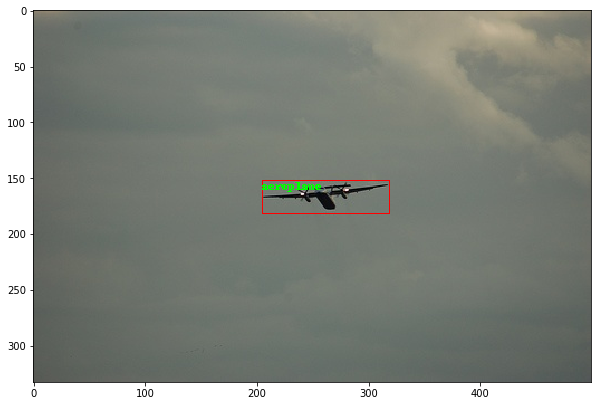

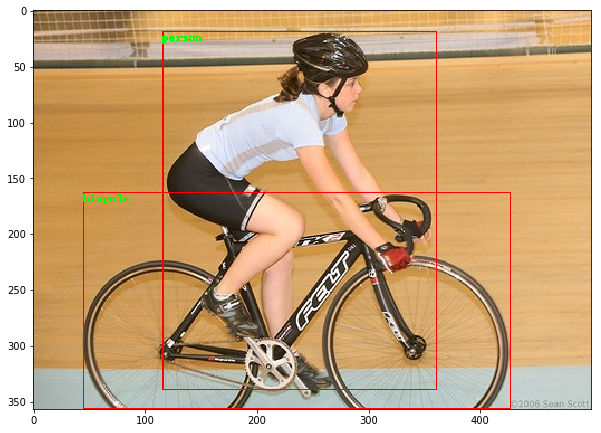

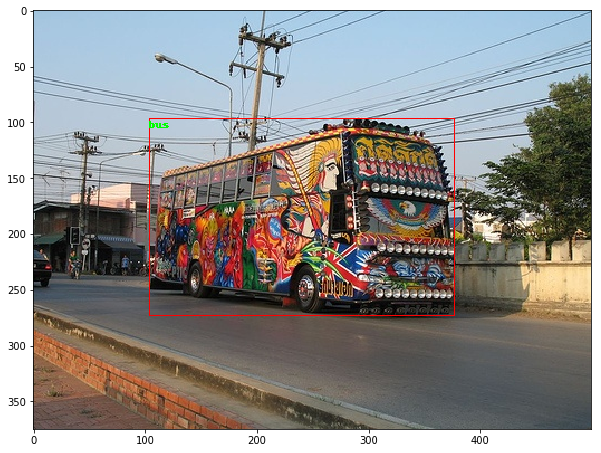

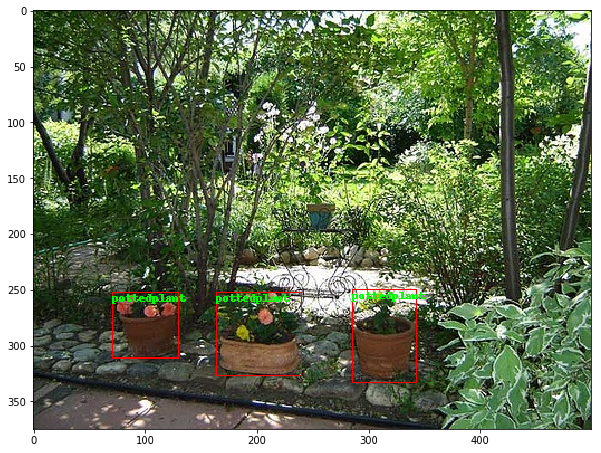

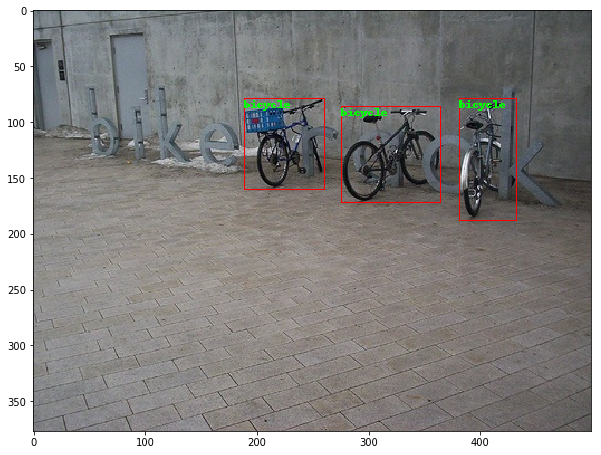

In [6]:
for i in range(5):
    idx = np.random.randint(0, len(ds_train.names)+1)
    _imgpath = os.path.join('VOCdevkit_2007/VOC2007/', 'JPEGImages', ds_train.names[idx]+'.jpg')
    img = Image.open(_imgpath).convert('RGB')
    draw = ImageDraw.Draw(img)
    for j in range(len(ds_train.box_indices[idx])):
        obj = ds_train.box_indices[idx][j]
        draw.rectangle(list(obj), outline=(255,0,0))
        draw.text(list(obj[0:2]), ds_train.classes[ds_train.label_order[idx][j]], fill=(0,255,0))
    plt.figure(figsize = (10,10))
    plt.imshow(np.array(img))
    ex=np.array(img)
    print(np.var(ex), np.mean(ex))

# Classification

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=32, 
                                               shuffle=True,
                                               num_workers=1)


In [9]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=128, 
                                               shuffle=True,
                                               num_workers=1)

In [10]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [11]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels, _) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss)
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        print('mAP: {0:.4f}'.format(mAP))
        print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

## Modifying the network 

The network you are given as is will allow you to reach around 0.15-0.2 mAP. To meet the benchmark for this assignment you will need to improve the network. There are a variety of different approaches you should try:

* Network architecture changes
    * Number of layers: try adding layers to make your network deeper
    * Batch normalization: adding batch norm between layers will likely give you a significant performance increase
    * Residual connections: as you increase the depth of your network, you will find that having residual connections like those in ResNet architectures will be helpful
* Optimizer: Instead of plain SGD, you may want to add a learning rate schedule, add momentum, or use one of the other optimizers you have learned about like Adam. Check the `torch.optim` package for other optimizers
* Data augmentation: You should use the `torchvision.transforms` module to try adding random resized crops and horizontal flips of the input data. Check `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip` for this
* Epochs: Once you have found a generally good hyperparameter setting try training for more epochs
* Loss function: You might want to add weighting to the `MultiLabelSoftMarginLoss` for classes that are less well represented or experiment with a different loss function



In [12]:
classifier = Classifier(SHAPE).to(device)
criterion = nn.BCEWithLogitsLoss(weight=class_weights) 
#optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01, weight_decay = 0.0001)
optimizer = torch.optim.Adadelta(classifier.parameters(), weight_decay=0.0008)
# You can can use this function to reload a network you have already saved previously
#classifier.load_state_dict(torch.load('voc_classifier.pth'))

criterion = nn.BCEWithLogitsLoss(weight=class_weights)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0015, weight_decay=0.002)

In [13]:
# Training the Classifier
NUM_EPOCHS = 800
TEST_FREQUENCY = 5

for epoch in range(1, NUM_EPOCHS+1):
    print("Starting epoch number " + str(epoch))
    train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    if(epoch%TEST_FREQUENCY==0):
        torch.save(classifier.state_dict(), './voc_classifier.pth')
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
        

Starting epoch number 1
Loss for Training on Epoch 1 is 1.8697606325149536
Starting epoch number 2
Loss for Training on Epoch 2 is 1.4394681453704834
Starting epoch number 3
Loss for Training on Epoch 3 is 1.4064756631851196
Starting epoch number 4
Loss for Training on Epoch 4 is 1.3764361143112183
Starting epoch number 5
Loss for Training on Epoch 5 is 1.3571983575820923
-------  Class: aeroplane        AP:   0.4073  -------
-------  Class: bicycle          AP:   0.0647  -------
-------  Class: bird             AP:   0.1131  -------
-------  Class: boat             AP:   0.3151  -------
-------  Class: bottle           AP:   0.1056  -------
-------  Class: bus              AP:   0.1023  -------
-------  Class: car              AP:   0.3638  -------
-------  Class: cat              AP:   0.1279  -------
-------  Class: chair            AP:   0.2711  -------
-------  Class: cow              AP:   0.0616  -------
-------  Class: diningtable      AP:   0.2155  -------
-------  Class: dog 

Loss for Training on Epoch 28 is 1.1065651178359985
Starting epoch number 29
Loss for Training on Epoch 29 is 1.1067051887512207
Starting epoch number 30
Loss for Training on Epoch 30 is 1.1148464679718018
-------  Class: aeroplane        AP:   0.5537  -------
-------  Class: bicycle          AP:   0.2200  -------
-------  Class: bird             AP:   0.1442  -------
-------  Class: boat             AP:   0.4134  -------
-------  Class: bottle           AP:   0.1298  -------
-------  Class: bus              AP:   0.1584  -------
-------  Class: car              AP:   0.4851  -------
-------  Class: cat              AP:   0.1945  -------
-------  Class: chair            AP:   0.3072  -------
-------  Class: cow              AP:   0.0948  -------
-------  Class: diningtable      AP:   0.2980  -------
-------  Class: dog              AP:   0.1726  -------
-------  Class: horse            AP:   0.3805  -------
-------  Class: motorbike        AP:   0.2440  -------
-------  Class: person  

Loss for Training on Epoch 55 is 0.9930465221405029
-------  Class: aeroplane        AP:   0.5709  -------
-------  Class: bicycle          AP:   0.2804  -------
-------  Class: bird             AP:   0.1908  -------
-------  Class: boat             AP:   0.4500  -------
-------  Class: bottle           AP:   0.1249  -------
-------  Class: bus              AP:   0.1368  -------
-------  Class: car              AP:   0.5243  -------
-------  Class: cat              AP:   0.2175  -------
-------  Class: chair            AP:   0.3909  -------
-------  Class: cow              AP:   0.1260  -------
-------  Class: diningtable      AP:   0.3039  -------
-------  Class: dog              AP:   0.2127  -------
-------  Class: horse            AP:   0.4524  -------
-------  Class: motorbike        AP:   0.2978  -------
-------  Class: person           AP:   0.6452  -------
-------  Class: pottedplant      AP:   0.1595  -------
-------  Class: sheep            AP:   0.0947  -------
-------  Clas

Loss for Training on Epoch 81 is 0.9047685265541077
Starting epoch number 82
Loss for Training on Epoch 82 is 0.8884726166725159
Starting epoch number 83
Loss for Training on Epoch 83 is 0.9110419154167175
Starting epoch number 84
Loss for Training on Epoch 84 is 0.8760213851928711
Starting epoch number 85
Loss for Training on Epoch 85 is 0.8754217624664307
-------  Class: aeroplane        AP:   0.5884  -------
-------  Class: bicycle          AP:   0.2747  -------
-------  Class: bird             AP:   0.1877  -------
-------  Class: boat             AP:   0.4037  -------
-------  Class: bottle           AP:   0.0991  -------
-------  Class: bus              AP:   0.2191  -------
-------  Class: car              AP:   0.5167  -------
-------  Class: cat              AP:   0.2395  -------
-------  Class: chair            AP:   0.4005  -------
-------  Class: cow              AP:   0.1224  -------
-------  Class: diningtable      AP:   0.3020  -------
-------  Class: dog              AP

Loss for Training on Epoch 108 is 0.8457595109939575
Starting epoch number 109
Loss for Training on Epoch 109 is 0.8435919284820557
Starting epoch number 110
Loss for Training on Epoch 110 is 0.8303646445274353
-------  Class: aeroplane        AP:   0.5421  -------
-------  Class: bicycle          AP:   0.2356  -------
-------  Class: bird             AP:   0.2019  -------
-------  Class: boat             AP:   0.3918  -------
-------  Class: bottle           AP:   0.1160  -------
-------  Class: bus              AP:   0.1407  -------
-------  Class: car              AP:   0.5412  -------
-------  Class: cat              AP:   0.2374  -------
-------  Class: chair            AP:   0.3760  -------
-------  Class: cow              AP:   0.1202  -------
-------  Class: diningtable      AP:   0.2800  -------
-------  Class: dog              AP:   0.2180  -------
-------  Class: horse            AP:   0.4833  -------
-------  Class: motorbike        AP:   0.2804  -------
-------  Class: per

Loss for Training on Epoch 134 is 0.8229314088821411
Starting epoch number 135
Loss for Training on Epoch 135 is 0.8266412019729614
-------  Class: aeroplane        AP:   0.5532  -------
-------  Class: bicycle          AP:   0.2380  -------
-------  Class: bird             AP:   0.2170  -------
-------  Class: boat             AP:   0.4152  -------
-------  Class: bottle           AP:   0.1459  -------
-------  Class: bus              AP:   0.1896  -------
-------  Class: car              AP:   0.5496  -------
-------  Class: cat              AP:   0.2999  -------
-------  Class: chair            AP:   0.4028  -------
-------  Class: cow              AP:   0.1173  -------
-------  Class: diningtable      AP:   0.3782  -------
-------  Class: dog              AP:   0.2157  -------
-------  Class: horse            AP:   0.4621  -------
-------  Class: motorbike        AP:   0.4128  -------
-------  Class: person           AP:   0.6517  -------
-------  Class: pottedplant      AP:   0.13

Loss for Training on Epoch 160 is 0.7825769782066345
-------  Class: aeroplane        AP:   0.6024  -------
-------  Class: bicycle          AP:   0.3121  -------
-------  Class: bird             AP:   0.2160  -------
-------  Class: boat             AP:   0.3844  -------
-------  Class: bottle           AP:   0.1404  -------
-------  Class: bus              AP:   0.2002  -------
-------  Class: car              AP:   0.5549  -------
-------  Class: cat              AP:   0.3020  -------
-------  Class: chair            AP:   0.4509  -------
-------  Class: cow              AP:   0.1184  -------
-------  Class: diningtable      AP:   0.3004  -------
-------  Class: dog              AP:   0.2340  -------
-------  Class: horse            AP:   0.4646  -------
-------  Class: motorbike        AP:   0.3918  -------
-------  Class: person           AP:   0.6813  -------
-------  Class: pottedplant      AP:   0.1449  -------
-------  Class: sheep            AP:   0.1099  -------
-------  Cla

Loss for Training on Epoch 186 is 0.785666823387146
Starting epoch number 187
Loss for Training on Epoch 187 is 0.791586697101593
Starting epoch number 188
Loss for Training on Epoch 188 is 0.7633647918701172
Starting epoch number 189
Loss for Training on Epoch 189 is 0.7747954726219177
Starting epoch number 190
Loss for Training on Epoch 190 is 0.764515221118927
-------  Class: aeroplane        AP:   0.5641  -------
-------  Class: bicycle          AP:   0.2872  -------
-------  Class: bird             AP:   0.1759  -------
-------  Class: boat             AP:   0.3300  -------
-------  Class: bottle           AP:   0.0917  -------
-------  Class: bus              AP:   0.1290  -------
-------  Class: car              AP:   0.4803  -------
-------  Class: cat              AP:   0.1977  -------
-------  Class: chair            AP:   0.3684  -------
-------  Class: cow              AP:   0.0578  -------
-------  Class: diningtable      AP:   0.2288  -------
-------  Class: dog          

Loss for Training on Epoch 212 is 0.7833054661750793
Starting epoch number 213
Loss for Training on Epoch 213 is 0.7527004480361938
Starting epoch number 214
Loss for Training on Epoch 214 is 0.756175696849823
Starting epoch number 215
Loss for Training on Epoch 215 is 0.7608942985534668
-------  Class: aeroplane        AP:   0.5893  -------
-------  Class: bicycle          AP:   0.2869  -------
-------  Class: bird             AP:   0.2176  -------
-------  Class: boat             AP:   0.3468  -------
-------  Class: bottle           AP:   0.1042  -------
-------  Class: bus              AP:   0.1576  -------
-------  Class: car              AP:   0.4983  -------
-------  Class: cat              AP:   0.2671  -------
-------  Class: chair            AP:   0.3863  -------
-------  Class: cow              AP:   0.1244  -------
-------  Class: diningtable      AP:   0.2463  -------
-------  Class: dog              AP:   0.2850  -------
-------  Class: horse            AP:   0.4732  ----

Loss for Training on Epoch 238 is 0.7846602201461792
Starting epoch number 239
Loss for Training on Epoch 239 is 0.7639484405517578
Starting epoch number 240
Loss for Training on Epoch 240 is 0.760916531085968
-------  Class: aeroplane        AP:   0.6051  -------
-------  Class: bicycle          AP:   0.3240  -------
-------  Class: bird             AP:   0.2336  -------
-------  Class: boat             AP:   0.4374  -------
-------  Class: bottle           AP:   0.1410  -------
-------  Class: bus              AP:   0.2171  -------
-------  Class: car              AP:   0.5549  -------
-------  Class: cat              AP:   0.2580  -------
-------  Class: chair            AP:   0.4549  -------
-------  Class: cow              AP:   0.1015  -------
-------  Class: diningtable      AP:   0.3407  -------
-------  Class: dog              AP:   0.2559  -------
-------  Class: horse            AP:   0.4922  -------
-------  Class: motorbike        AP:   0.4124  -------
-------  Class: pers

Loss for Training on Epoch 264 is 0.7600668668746948
Starting epoch number 265
Loss for Training on Epoch 265 is 0.7342665195465088
-------  Class: aeroplane        AP:   0.5234  -------
-------  Class: bicycle          AP:   0.2768  -------
-------  Class: bird             AP:   0.1737  -------
-------  Class: boat             AP:   0.3015  -------
-------  Class: bottle           AP:   0.1123  -------
-------  Class: bus              AP:   0.2065  -------
-------  Class: car              AP:   0.4676  -------
-------  Class: cat              AP:   0.2317  -------
-------  Class: chair            AP:   0.3211  -------
-------  Class: cow              AP:   0.1037  -------
-------  Class: diningtable      AP:   0.1947  -------
-------  Class: dog              AP:   0.1899  -------
-------  Class: horse            AP:   0.3637  -------
-------  Class: motorbike        AP:   0.2914  -------
-------  Class: person           AP:   0.6241  -------
-------  Class: pottedplant      AP:   0.10

Loss for Training on Epoch 290 is 0.7110013961791992
-------  Class: aeroplane        AP:   0.6133  -------
-------  Class: bicycle          AP:   0.2657  -------
-------  Class: bird             AP:   0.2136  -------
-------  Class: boat             AP:   0.4246  -------
-------  Class: bottle           AP:   0.1066  -------
-------  Class: bus              AP:   0.2993  -------
-------  Class: car              AP:   0.5133  -------
-------  Class: cat              AP:   0.3193  -------
-------  Class: chair            AP:   0.3928  -------
-------  Class: cow              AP:   0.1405  -------
-------  Class: diningtable      AP:   0.2170  -------
-------  Class: dog              AP:   0.2326  -------
-------  Class: horse            AP:   0.4042  -------
-------  Class: motorbike        AP:   0.1780  -------
-------  Class: person           AP:   0.6969  -------
-------  Class: pottedplant      AP:   0.0862  -------
-------  Class: sheep            AP:   0.1505  -------
-------  Cla

Loss for Training on Epoch 316 is 0.7535583972930908
Starting epoch number 317
Loss for Training on Epoch 317 is 0.7302253246307373
Starting epoch number 318
Loss for Training on Epoch 318 is 0.7244179248809814
Starting epoch number 319
Loss for Training on Epoch 319 is 0.7179450392723083
Starting epoch number 320
Loss for Training on Epoch 320 is 0.7229108810424805
-------  Class: aeroplane        AP:   0.5907  -------
-------  Class: bicycle          AP:   0.2599  -------
-------  Class: bird             AP:   0.2144  -------
-------  Class: boat             AP:   0.4058  -------
-------  Class: bottle           AP:   0.1273  -------
-------  Class: bus              AP:   0.2103  -------
-------  Class: car              AP:   0.5578  -------
-------  Class: cat              AP:   0.2611  -------
-------  Class: chair            AP:   0.4043  -------
-------  Class: cow              AP:   0.1190  -------
-------  Class: diningtable      AP:   0.3420  -------
-------  Class: dog       

Loss for Training on Epoch 342 is 0.7562474012374878
Starting epoch number 343
Loss for Training on Epoch 343 is 0.7329656481742859
Starting epoch number 344
Loss for Training on Epoch 344 is 0.7054195404052734
Starting epoch number 345
Loss for Training on Epoch 345 is 0.710490882396698
-------  Class: aeroplane        AP:   0.6199  -------
-------  Class: bicycle          AP:   0.2495  -------
-------  Class: bird             AP:   0.2467  -------
-------  Class: boat             AP:   0.4075  -------
-------  Class: bottle           AP:   0.1708  -------
-------  Class: bus              AP:   0.3102  -------
-------  Class: car              AP:   0.5493  -------
-------  Class: cat              AP:   0.2693  -------
-------  Class: chair            AP:   0.4459  -------
-------  Class: cow              AP:   0.1205  -------
-------  Class: diningtable      AP:   0.3599  -------
-------  Class: dog              AP:   0.2880  -------
-------  Class: horse            AP:   0.4974  ----

Loss for Training on Epoch 368 is 0.7284005284309387
Starting epoch number 369
Loss for Training on Epoch 369 is 0.7162339687347412
Starting epoch number 370
Loss for Training on Epoch 370 is 0.7273982167243958
-------  Class: aeroplane        AP:   0.5657  -------
-------  Class: bicycle          AP:   0.2518  -------
-------  Class: bird             AP:   0.2267  -------
-------  Class: boat             AP:   0.4480  -------
-------  Class: bottle           AP:   0.1339  -------
-------  Class: bus              AP:   0.2448  -------
-------  Class: car              AP:   0.5572  -------
-------  Class: cat              AP:   0.2990  -------
-------  Class: chair            AP:   0.4417  -------
-------  Class: cow              AP:   0.1141  -------
-------  Class: diningtable      AP:   0.3276  -------
-------  Class: dog              AP:   0.2596  -------
-------  Class: horse            AP:   0.4600  -------
-------  Class: motorbike        AP:   0.3501  -------
-------  Class: per

Loss for Training on Epoch 394 is 0.7206587195396423
Starting epoch number 395
Loss for Training on Epoch 395 is 0.7036920189857483
-------  Class: aeroplane        AP:   0.5660  -------
-------  Class: bicycle          AP:   0.2378  -------
-------  Class: bird             AP:   0.2444  -------
-------  Class: boat             AP:   0.4226  -------
-------  Class: bottle           AP:   0.0843  -------
-------  Class: bus              AP:   0.1931  -------
-------  Class: car              AP:   0.5292  -------
-------  Class: cat              AP:   0.2214  -------
-------  Class: chair            AP:   0.3873  -------
-------  Class: cow              AP:   0.1407  -------
-------  Class: diningtable      AP:   0.2777  -------
-------  Class: dog              AP:   0.2094  -------
-------  Class: horse            AP:   0.4654  -------
-------  Class: motorbike        AP:   0.3574  -------
-------  Class: person           AP:   0.6796  -------
-------  Class: pottedplant      AP:   0.11

Loss for Training on Epoch 420 is 0.7130171656608582
-------  Class: aeroplane        AP:   0.5514  -------
-------  Class: bicycle          AP:   0.3210  -------
-------  Class: bird             AP:   0.2233  -------
-------  Class: boat             AP:   0.3789  -------
-------  Class: bottle           AP:   0.1245  -------
-------  Class: bus              AP:   0.3069  -------
-------  Class: car              AP:   0.5180  -------
-------  Class: cat              AP:   0.3059  -------
-------  Class: chair            AP:   0.4416  -------
-------  Class: cow              AP:   0.1371  -------
-------  Class: diningtable      AP:   0.3599  -------
-------  Class: dog              AP:   0.2542  -------
-------  Class: horse            AP:   0.4083  -------
-------  Class: motorbike        AP:   0.4370  -------
-------  Class: person           AP:   0.6910  -------
-------  Class: pottedplant      AP:   0.1183  -------
-------  Class: sheep            AP:   0.1219  -------
-------  Cla

Loss for Training on Epoch 446 is 0.7182244658470154
Starting epoch number 447
Loss for Training on Epoch 447 is 0.7064335942268372
Starting epoch number 448
Loss for Training on Epoch 448 is 0.6848753690719604
Starting epoch number 449
Loss for Training on Epoch 449 is 0.6991700530052185
Starting epoch number 450
Loss for Training on Epoch 450 is 0.7322748303413391
-------  Class: aeroplane        AP:   0.5845  -------
-------  Class: bicycle          AP:   0.2154  -------
-------  Class: bird             AP:   0.2041  -------
-------  Class: boat             AP:   0.4375  -------
-------  Class: bottle           AP:   0.1295  -------
-------  Class: bus              AP:   0.2497  -------
-------  Class: car              AP:   0.5112  -------
-------  Class: cat              AP:   0.2658  -------
-------  Class: chair            AP:   0.3901  -------
-------  Class: cow              AP:   0.1180  -------
-------  Class: diningtable      AP:   0.2600  -------
-------  Class: dog       

Loss for Training on Epoch 472 is 0.7045791149139404
Starting epoch number 473
Loss for Training on Epoch 473 is 0.7081605195999146
Starting epoch number 474
Loss for Training on Epoch 474 is 0.7213695049285889
Starting epoch number 475
Loss for Training on Epoch 475 is 0.7104917168617249
-------  Class: aeroplane        AP:   0.5414  -------
-------  Class: bicycle          AP:   0.2420  -------
-------  Class: bird             AP:   0.2067  -------
-------  Class: boat             AP:   0.4450  -------
-------  Class: bottle           AP:   0.1447  -------
-------  Class: bus              AP:   0.2714  -------
-------  Class: car              AP:   0.5412  -------
-------  Class: cat              AP:   0.2929  -------
-------  Class: chair            AP:   0.4248  -------
-------  Class: cow              AP:   0.1203  -------
-------  Class: diningtable      AP:   0.3174  -------
-------  Class: dog              AP:   0.2450  -------
-------  Class: horse            AP:   0.4308  ---

Loss for Training on Epoch 498 is 0.7072589993476868
Starting epoch number 499
Loss for Training on Epoch 499 is 0.6959722638130188
Starting epoch number 500
Loss for Training on Epoch 500 is 0.7034575343132019
-------  Class: aeroplane        AP:   0.5658  -------
-------  Class: bicycle          AP:   0.2842  -------
-------  Class: bird             AP:   0.2030  -------
-------  Class: boat             AP:   0.2916  -------
-------  Class: bottle           AP:   0.0691  -------
-------  Class: bus              AP:   0.1549  -------
-------  Class: car              AP:   0.5266  -------
-------  Class: cat              AP:   0.2560  -------
-------  Class: chair            AP:   0.3740  -------
-------  Class: cow              AP:   0.1189  -------
-------  Class: diningtable      AP:   0.2410  -------
-------  Class: dog              AP:   0.2740  -------
-------  Class: horse            AP:   0.4686  -------
-------  Class: motorbike        AP:   0.3244  -------
-------  Class: per

Loss for Training on Epoch 524 is 0.7033603191375732
Starting epoch number 525
Loss for Training on Epoch 525 is 0.7088391780853271
-------  Class: aeroplane        AP:   0.5915  -------
-------  Class: bicycle          AP:   0.2180  -------
-------  Class: bird             AP:   0.2492  -------
-------  Class: boat             AP:   0.4478  -------
-------  Class: bottle           AP:   0.1750  -------
-------  Class: bus              AP:   0.1699  -------
-------  Class: car              AP:   0.5284  -------
-------  Class: cat              AP:   0.2937  -------
-------  Class: chair            AP:   0.4254  -------
-------  Class: cow              AP:   0.1039  -------
-------  Class: diningtable      AP:   0.3223  -------
-------  Class: dog              AP:   0.2500  -------
-------  Class: horse            AP:   0.4907  -------
-------  Class: motorbike        AP:   0.3569  -------
-------  Class: person           AP:   0.7043  -------
-------  Class: pottedplant      AP:   0.17

Loss for Training on Epoch 550 is 0.7162385582923889
-------  Class: aeroplane        AP:   0.5258  -------
-------  Class: bicycle          AP:   0.1673  -------
-------  Class: bird             AP:   0.1982  -------
-------  Class: boat             AP:   0.4047  -------
-------  Class: bottle           AP:   0.0812  -------
-------  Class: bus              AP:   0.1979  -------
-------  Class: car              AP:   0.5122  -------
-------  Class: cat              AP:   0.2744  -------
-------  Class: chair            AP:   0.3329  -------
-------  Class: cow              AP:   0.1644  -------
-------  Class: diningtable      AP:   0.2345  -------
-------  Class: dog              AP:   0.1932  -------
-------  Class: horse            AP:   0.4271  -------
-------  Class: motorbike        AP:   0.3125  -------
-------  Class: person           AP:   0.6506  -------
-------  Class: pottedplant      AP:   0.1262  -------
-------  Class: sheep            AP:   0.1214  -------
-------  Cla

Loss for Training on Epoch 576 is 0.7076667547225952
Starting epoch number 577
Loss for Training on Epoch 577 is 0.7012935876846313
Starting epoch number 578
Loss for Training on Epoch 578 is 0.7027011513710022
Starting epoch number 579
Loss for Training on Epoch 579 is 0.6992038488388062
Starting epoch number 580
Loss for Training on Epoch 580 is 0.7100346684455872
-------  Class: aeroplane        AP:   0.4736  -------
-------  Class: bicycle          AP:   0.2337  -------
-------  Class: bird             AP:   0.1963  -------
-------  Class: boat             AP:   0.3588  -------
-------  Class: bottle           AP:   0.0628  -------
-------  Class: bus              AP:   0.1647  -------
-------  Class: car              AP:   0.4074  -------
-------  Class: cat              AP:   0.1679  -------
-------  Class: chair            AP:   0.2238  -------
-------  Class: cow              AP:   0.0700  -------
-------  Class: diningtable      AP:   0.1245  -------
-------  Class: dog       

Loss for Training on Epoch 602 is 0.7049376368522644
Starting epoch number 603
Loss for Training on Epoch 603 is 0.6956570744514465
Starting epoch number 604
Loss for Training on Epoch 604 is 0.6913168430328369
Starting epoch number 605
Loss for Training on Epoch 605 is 0.692386269569397
-------  Class: aeroplane        AP:   0.5671  -------
-------  Class: bicycle          AP:   0.1600  -------
-------  Class: bird             AP:   0.1699  -------
-------  Class: boat             AP:   0.3731  -------
-------  Class: bottle           AP:   0.0933  -------
-------  Class: bus              AP:   0.1791  -------
-------  Class: car              AP:   0.5049  -------
-------  Class: cat              AP:   0.3011  -------
-------  Class: chair            AP:   0.3679  -------
-------  Class: cow              AP:   0.1025  -------
-------  Class: diningtable      AP:   0.2834  -------
-------  Class: dog              AP:   0.2326  -------
-------  Class: horse            AP:   0.3101  ----

Loss for Training on Epoch 628 is 0.6931990385055542
Starting epoch number 629
Loss for Training on Epoch 629 is 0.6826736927032471
Starting epoch number 630
Loss for Training on Epoch 630 is 0.7027663588523865
-------  Class: aeroplane        AP:   0.5573  -------
-------  Class: bicycle          AP:   0.1848  -------
-------  Class: bird             AP:   0.2274  -------
-------  Class: boat             AP:   0.4591  -------
-------  Class: bottle           AP:   0.1109  -------
-------  Class: bus              AP:   0.1323  -------
-------  Class: car              AP:   0.5294  -------
-------  Class: cat              AP:   0.2790  -------
-------  Class: chair            AP:   0.3904  -------
-------  Class: cow              AP:   0.1306  -------
-------  Class: diningtable      AP:   0.3173  -------
-------  Class: dog              AP:   0.2439  -------
-------  Class: horse            AP:   0.4729  -------
-------  Class: motorbike        AP:   0.4528  -------
-------  Class: per

Loss for Training on Epoch 654 is 0.7047411799430847
Starting epoch number 655
Loss for Training on Epoch 655 is 0.6761180758476257
-------  Class: aeroplane        AP:   0.5981  -------
-------  Class: bicycle          AP:   0.2084  -------
-------  Class: bird             AP:   0.2252  -------
-------  Class: boat             AP:   0.4361  -------
-------  Class: bottle           AP:   0.1719  -------
-------  Class: bus              AP:   0.1750  -------
-------  Class: car              AP:   0.5496  -------
-------  Class: cat              AP:   0.3074  -------
-------  Class: chair            AP:   0.4626  -------
-------  Class: cow              AP:   0.1027  -------
-------  Class: diningtable      AP:   0.3567  -------
-------  Class: dog              AP:   0.2412  -------
-------  Class: horse            AP:   0.4416  -------
-------  Class: motorbike        AP:   0.3453  -------
-------  Class: person           AP:   0.6878  -------
-------  Class: pottedplant      AP:   0.15

Loss for Training on Epoch 680 is 0.6766709685325623
-------  Class: aeroplane        AP:   0.5837  -------
-------  Class: bicycle          AP:   0.3246  -------
-------  Class: bird             AP:   0.2209  -------
-------  Class: boat             AP:   0.4351  -------
-------  Class: bottle           AP:   0.1281  -------
-------  Class: bus              AP:   0.2688  -------
-------  Class: car              AP:   0.5020  -------
-------  Class: cat              AP:   0.3285  -------
-------  Class: chair            AP:   0.4205  -------
-------  Class: cow              AP:   0.1242  -------
-------  Class: diningtable      AP:   0.3088  -------
-------  Class: dog              AP:   0.2757  -------
-------  Class: horse            AP:   0.4604  -------
-------  Class: motorbike        AP:   0.3697  -------
-------  Class: person           AP:   0.6945  -------
-------  Class: pottedplant      AP:   0.1485  -------
-------  Class: sheep            AP:   0.1041  -------
-------  Cla

Loss for Training on Epoch 706 is 0.7004401683807373
Starting epoch number 707
Loss for Training on Epoch 707 is 0.6811751127243042
Starting epoch number 708
Loss for Training on Epoch 708 is 0.6831638216972351
Starting epoch number 709
Loss for Training on Epoch 709 is 0.6765410900115967
Starting epoch number 710
Loss for Training on Epoch 710 is 0.7046917080879211
-------  Class: aeroplane        AP:   0.6006  -------
-------  Class: bicycle          AP:   0.1798  -------
-------  Class: bird             AP:   0.1966  -------
-------  Class: boat             AP:   0.3885  -------
-------  Class: bottle           AP:   0.1102  -------
-------  Class: bus              AP:   0.1683  -------
-------  Class: car              AP:   0.4485  -------
-------  Class: cat              AP:   0.3039  -------
-------  Class: chair            AP:   0.4113  -------
-------  Class: cow              AP:   0.1399  -------
-------  Class: diningtable      AP:   0.2987  -------
-------  Class: dog       

Loss for Training on Epoch 732 is 0.6987735033035278
Starting epoch number 733
Loss for Training on Epoch 733 is 0.6809384822845459
Starting epoch number 734
Loss for Training on Epoch 734 is 0.7031249403953552
Starting epoch number 735
Loss for Training on Epoch 735 is 0.6849785447120667
-------  Class: aeroplane        AP:   0.6294  -------
-------  Class: bicycle          AP:   0.3200  -------
-------  Class: bird             AP:   0.2102  -------
-------  Class: boat             AP:   0.4198  -------
-------  Class: bottle           AP:   0.1158  -------
-------  Class: bus              AP:   0.1314  -------
-------  Class: car              AP:   0.4862  -------
-------  Class: cat              AP:   0.2805  -------
-------  Class: chair            AP:   0.4018  -------
-------  Class: cow              AP:   0.1045  -------
-------  Class: diningtable      AP:   0.2437  -------
-------  Class: dog              AP:   0.1877  -------
-------  Class: horse            AP:   0.4709  ---

Loss for Training on Epoch 758 is 0.6813495755195618
Starting epoch number 759
Loss for Training on Epoch 759 is 0.6743482947349548
Starting epoch number 760
Loss for Training on Epoch 760 is 0.6895435452461243
-------  Class: aeroplane        AP:   0.6111  -------
-------  Class: bicycle          AP:   0.2738  -------
-------  Class: bird             AP:   0.2413  -------
-------  Class: boat             AP:   0.4167  -------
-------  Class: bottle           AP:   0.1004  -------
-------  Class: bus              AP:   0.0975  -------
-------  Class: car              AP:   0.5243  -------
-------  Class: cat              AP:   0.2719  -------
-------  Class: chair            AP:   0.4516  -------
-------  Class: cow              AP:   0.1210  -------
-------  Class: diningtable      AP:   0.2724  -------
-------  Class: dog              AP:   0.2327  -------
-------  Class: horse            AP:   0.4188  -------
-------  Class: motorbike        AP:   0.4249  -------
-------  Class: per

Loss for Training on Epoch 784 is 0.6726853251457214
Starting epoch number 785
Loss for Training on Epoch 785 is 0.6948856115341187
-------  Class: aeroplane        AP:   0.5912  -------
-------  Class: bicycle          AP:   0.2626  -------
-------  Class: bird             AP:   0.2644  -------
-------  Class: boat             AP:   0.3997  -------
-------  Class: bottle           AP:   0.1181  -------
-------  Class: bus              AP:   0.1759  -------
-------  Class: car              AP:   0.5370  -------
-------  Class: cat              AP:   0.2501  -------
-------  Class: chair            AP:   0.3305  -------
-------  Class: cow              AP:   0.1422  -------
-------  Class: diningtable      AP:   0.2541  -------
-------  Class: dog              AP:   0.2008  -------
-------  Class: horse            AP:   0.4119  -------
-------  Class: motorbike        AP:   0.4187  -------
-------  Class: person           AP:   0.6628  -------
-------  Class: pottedplant      AP:   0.15

In [14]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './voc_classifier.pth')

In [15]:
mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
print('Evaluating classifier')
print("Mean Precision Score for Training is "+ str(mAP_val))

mAP_train, train_loss, _ = test_classifier(train_loader, classifier, criterion)
print('Evaluating classifier')
print("Mean Precision Score for Training is "+ str(mAP_train))

-------  Class: aeroplane        AP:   0.6100  -------
-------  Class: bicycle          AP:   0.2834  -------
-------  Class: bird             AP:   0.2438  -------
-------  Class: boat             AP:   0.3945  -------
-------  Class: bottle           AP:   0.0979  -------
-------  Class: bus              AP:   0.2124  -------
-------  Class: car              AP:   0.5119  -------
-------  Class: cat              AP:   0.3020  -------
-------  Class: chair            AP:   0.3893  -------
-------  Class: cow              AP:   0.1110  -------
-------  Class: diningtable      AP:   0.3101  -------
-------  Class: dog              AP:   0.2496  -------
-------  Class: horse            AP:   0.3892  -------
-------  Class: motorbike        AP:   0.3326  -------
-------  Class: person           AP:   0.6765  -------
-------  Class: pottedplant      AP:   0.1312  -------
-------  Class: sheep            AP:   0.0821  -------
-------  Class: sofa             AP:   0.3073  -------
-------  C

# Evaluate on test set



In [16]:
ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=50, 
                                               shuffle=False,
                                               num_workers=1)

mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

-------  Class: aeroplane        AP:   0.5893  -------
-------  Class: bicycle          AP:   0.3090  -------
-------  Class: bird             AP:   0.2504  -------
-------  Class: boat             AP:   0.3573  -------
-------  Class: bottle           AP:   0.0847  -------
-------  Class: bus              AP:   0.2437  -------
-------  Class: car              AP:   0.4950  -------
-------  Class: cat              AP:   0.2407  -------
-------  Class: chair            AP:   0.3704  -------
-------  Class: cow              AP:   0.0831  -------
-------  Class: diningtable      AP:   0.2216  -------
-------  Class: dog              AP:   0.2186  -------
-------  Class: horse            AP:   0.4638  -------
-------  Class: motorbike        AP:   0.3051  -------
-------  Class: person           AP:   0.7035  -------
-------  Class: pottedplant      AP:   0.1603  -------
-------  Class: sheep            AP:   0.1305  -------
-------  Class: sofa             AP:   0.3005  -------
-------  C

In [16]:
output_submission_csv('my_solution.csv', test_aps)